### Importo as bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dt
import matplotlib.pyplot as plt

### Importo os dados dos setores

In [2]:
# Importo a plan com os dados do ibrx
ibrx_compo = pd.read_csv('IBrx Compo.csv', index_col=0)

# Transformo em uma lista
all_tickers = []
for column in range(0, len(ibrx_compo.columns)):
    for row in range(0, len(ibrx_compo.index)):
        if ibrx_compo.iloc[row, column] not in all_tickers and str(ibrx_compo.iloc[row, column]) != 'nan':
            all_tickers.append(ibrx_compo.iloc[row, column])

### Puxo os dados do yahoo

In [3]:
%%time
# Defino qual será a data de início dos dataframes de preços
start_date = '2010-01-01'

# Crio um dicionário que irá conter a série de preços de cada ação
prices = {}

# Pego apenas a coluna Adjusted Close porque é o que me interessa
errors = []
for s in range(0, len(all_tickers)):
    try:
        prices.update({all_tickers[s]:dt.DataReader(all_tickers[s], start=start_date, data_source='yahoo')['Adj Close']})
    except:
        pass
        errors.append(all_tickers[s])      

Wall time: 4min 12s


In [4]:
# Pego os dados do ibovespa
ibov = dt.DataReader('^BVSP', start=start_date, data_source='yahoo')['Adj Close']    

In [5]:
# Crio uma lista de preços que irá conter um pd.Series de preços para cada ação 
prices_list = []
for stock in prices.keys():
    prices_list.append(prices[stock])    

In [6]:
# Apago as acoes nao encontradas
for e in errors:
    if e in all_tickers:
        all_tickers.remove(e)

In [7]:
# Agrupo os preços em apenas um dataframe
prices_df = pd.concat(prices_list, axis=1)
prices_df.columns = all_tickers

### Tratando a base de dados

In [8]:
# Crio uma função que preenche dados vazios
def fill_values(df):
    for i in df.columns.values:
        init = df[i].first_valid_index()
        end = df[i].last_valid_index()
        df[i].loc[init:end]=df[i].loc[init:end].fillna(method='ffill')

In [9]:
# Preencho os valores descontinuos de precos
fill_values(prices_df)
prices_df.drop('TRPL4.SA', axis=1, inplace=True) #Estava com dados estranhos (saltos nos precos nao condizentes com a realidade)
prices_df['MGLU3.SA'] = prices_df['MGLU3.SA']+1 #Estava com precos negativos em 2014 (???)

### Metricas

In [10]:
# Calculo as medias moveis
MA15 = prices_df.rolling(15).mean()

# Calculo os desvios 
lower15 = MA15 - 2*prices_df.rolling(15).std()
upper15 = MA15 + 2*prices_df.rolling(15).std()

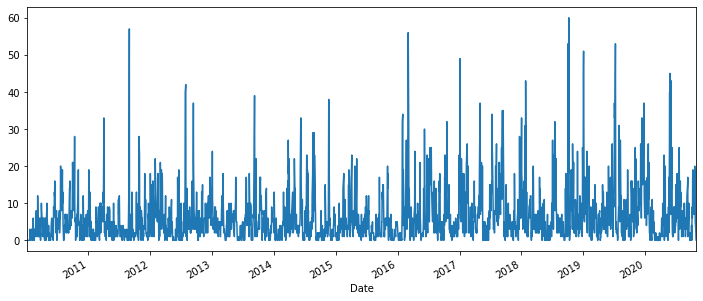

In [11]:
# Quando a oportunidade aparece
timing_buy = prices_df[prices_df<lower15]
timing_sell = prices_df[prices_df>upper15]

timing_sell.count(axis=1).plot(figsize=(12,5))

In [12]:
# Excluo os dias com mais de 10 acoes
new_timing = timing_buy[timing_buy.count(axis=1)<10]

timing_buy[:] = np.nan
timing_buy.loc[new_timing.index] = new_timing

# Sell
s_new_timing = timing_sell[timing_sell.count(axis=1)<10]

timing_sell[:] = np.nan
timing_sell.loc[s_new_timing.index] = s_new_timing

In [13]:
# Faco um dataframe que contem a data e as acoes que serao compradas
buys = {}
for date in timing_buy.index:
    buys.update({date:list(timing_buy.loc[date].dropna().index)})
    
buys_df = pd.DataFrame.from_dict(buys, orient='index')

# Faco um dataframe que contem a data e as acoes que serao vendidas
sells = {}
for date in timing_sell.index:
    sells.update({date:list(timing_sell.loc[date].dropna().index)})
    
sells_df = pd.DataFrame.from_dict(sells, orient='index')

In [14]:
# Faco o filtro do IBrX (se a acao nao estiver no indice no ano ela sera deletada da lista de compra)
for date in buys_df.index:
    buys = list(buys_df.loc[date].dropna())
    for b in range(0, len(buys)):
        if buys[b] not in list(ibrx_compo[str(date.year)]):
            buys_df.loc[date][b] = None
            
for date in sells_df.index:
    sells = list(sells_df.loc[date].dropna())
    for s in range(0, len(sells)):
        if sells[s] not in list(ibrx_compo[str(date.year)]):
            sells_df.loc[date][b] = None            

In [15]:
# Descubro quais acoes estao abaixo da media de 15 dias por mais de uma vez em 30 dias uteis 
roll_count = prices_df[prices_df<lower15].rolling(30).count()

s_roll_count = prices_df[prices_df<upper15].rolling(30).count()

### Retornos das estrategias

In [16]:
%%time
days = 1
b_returns = {}
for d in range(0,len(timing_buy.index)-days):
    #Buys
    # Seleciona as acoes com ordem de compra (d seria a data de compra e d+days a data da venda)
    df_tickers = prices_df.loc[timing_buy.index[d]:timing_buy.index[d+days],list(buys_df.loc[timing_buy.index[d]].dropna())].pct_change(days).tail(1)
    # Passa pelo filtro do rolling count
    list_count = roll_count.loc[timing_buy.index[d], list(df_tickers.columns)]
    df_tickers = df_tickers.drop(list(list_count[list_count>3].index), axis=1)
    
    # Retorno supondo equal weights
    b_date_return = df_tickers.mean(axis=1)
    #if str(date_return[0]) == 'nan':
    #    date_return[0] = ibov[timing.index].loc[timing.index[d]:timing.index[d+days]].pct_change().tail(1)[0]
    
    b_returns.update({b_date_return.index[0]:b_date_return[0]})


Wall time: 16 s


In [17]:
%%time
s_returns = {}
for d in range(0,len(timing_sell.index)-days):
    #Sells
    # Seleciona as acoes com ordem de venda (d seria a data de venda e d+days a data da compra)
    df_tickers = prices_df.loc[timing_sell.index[d]:timing_sell.index[d+days],list(sells_df.loc[timing_sell.index[d]].dropna())].pct_change(days).tail(1)
    # Passa pelo filtro do rolling count
    list_count = roll_count.loc[timing_sell.index[d], list(df_tickers.columns)]
    df_tickers = df_tickers.drop(list(list_count[list_count>3].index), axis=1)
    
    s_date_return = (df_tickers.mean(axis=1))*-1
    
    s_returns.update({s_date_return.index[0]:s_date_return[0]})

Wall time: 19 s


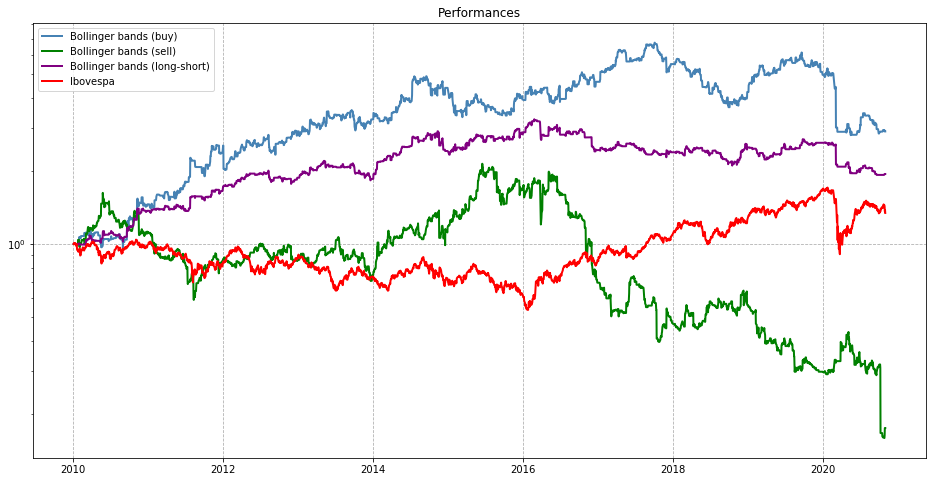

In [18]:
boll = (pd.Series(s_returns) + pd.Series(b_returns))/2

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)

ax.plot(pd.Series(b_returns).fillna(0).add(1).cumprod(), c='steelblue', label='Bollinger bands (buy)', lw=2)
ax.plot(pd.Series(s_returns).fillna(0).add(1).cumprod(), c='green', label='Bollinger bands (sell)', lw=2)
ax.plot(boll.fillna(0).add(1).cumprod(), c='purple', label='Bollinger bands (long-short)', lw=2)
ax.plot((ibov/ibov.iloc[0]), c='red', label='Ibovespa', lw=2)
ax.legend(loc='best')
ax.set_yscale('log')
ax.set_title('Performances')
ax.grid(True, linestyle='--')
plt.show()

## Estatisticas

In [19]:
corr = pd.Series(boll).fillna(0).corr(ibov.pct_change())
ibov_vol = (ibov.pct_change().dropna().std())*252**0.5
ibov_sharpe = (ibov.pct_change().dropna().mean())/(ibov.pct_change().dropna().std())*252**0.5
boll_vol_b = (pd.Series(b_returns).fillna(0).std())*252**0.5
boll_sharpe_b = (pd.Series(b_returns).fillna(0).mean())/(pd.Series(b_returns).fillna(0).std())*252**0.5
boll_vol_s = (pd.Series(s_returns).fillna(0).std())*252**0.5
boll_sharpe_s = (pd.Series(s_returns).fillna(0).mean())/(pd.Series(s_returns).fillna(0).std())*252**0.5
boll_vol_ls = (pd.Series(boll).fillna(0).std())*252**0.5
boll_sharpe_ls = (pd.Series(boll).fillna(0).mean())/(pd.Series(boll).fillna(0).std())*252**0.5

stats = pd.DataFrame(index=['Vol', 'Sharpe'], columns=['Ibov', 'B Bands (buy)', 'B Bands (sell)', 'B Bands (l-s)'])
stats['Ibov'] = [ibov_vol, ibov_sharpe]
stats['B Bands (buy)'] = [boll_vol_b,boll_sharpe_b]
stats['B Bands (sell)'] = [boll_vol_s,boll_sharpe_s]
stats['B Bands (l-s)'] = [boll_vol_ls,boll_sharpe_ls]
stats

,Ibov,B Bands (buy),B Bands (sell),B Bands (l-s)
Vol,0.253252,0.308223,0.42439,0.182340
Sharpe,0.236728,0.479621,-0.15197,0.430932


## Forzao

In [20]:
# %%time
# window = [10, 15, 20, 25, 30, 35, 40, 45]
# count = [1, 2 ,3, 4, 5]
# data = {}
# for w in window:
#     for c in count:
#         roll_count = prices_df[prices_df<lower15].rolling(w).count()
#         days = 1
#         returns = {}
#         for d in range(0,len(timing.index)-days):
#             # Seleciona as acoes com ordem de compra (d seria a data de compra e d+days a data da venda)
#             df_tickers = prices_df.loc[timing.index[d]:timing.index[d+days],list(buys_df.loc[timing.index[d]].dropna())].pct_change(days).tail(1)
#             # Passa pelo filtro do rolling count
#             list_count = roll_count.loc[timing.index[d], list(df_tickers.columns)]
#             df_tickers = df_tickers.drop(list(list_count[list_count>c].index), axis=1)

#             # Retorno supondo equal weights
#             date_return = df_tickers.mean(axis=1)
#             if str(date_return[0]) == 'nan':
#                 date_return[0] = ibov[timing.index].loc[timing.index[d]:timing.index[d+days]].pct_change().tail(1)[0]
#             returns.update({date_return.index[0]:date_return[0]})
#             perf = pd.Series(returns).fillna(0).add(1).cumprod()
            
#             data.update({str(w+c):[returns, perf]})

In [21]:
# alli = []
# for wc in data.keys():
#     alli.append(data[wc][1])

In [22]:
# alli_df = pd.concat(alli, axis=1)
# alli_df.columns = list(data.keys())